In [1]:
import h5py
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import copy

In [2]:
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set default size of plots

## Initialize Parameters for L Neural Network

In [4]:
def initialize_parameters_deep(layer_dim, seed = 3):

    """
    Arguments:
    layer_dim: Array with the dimensions of each layer of the network
    seed: random seed
    
    Return:
    W: weight matrix (n_l, n_l-1)
    b: bias vector (n_l, 1)
    
    """

    np.random.seed(seed)
    
    parameters = {}
    
    L = len(layer_dim) # Layers in the network
    
    for l in range(1, L):
        parameters["W" + str(l)] = np.random.randn(layer_dim[l], layer_dim[l-1]) * np.sqrt(2. / layer_dim[l-1])
        parameters["b" + str(l)] = np.zeros((layer_dim[l], 1))

    return parameters

**This is an example for Neural Network**


<img src="Images/1.png" width="600">   

## Forward Propagation

<img src="Images/2.png" width="600">  

<img src="Images/3.png" width="600">  

In [10]:
def linear_forward(A, W, b):

    """
    Arguments
    A: Values form the previous layer (A0 is the input layer with X values)
    W: weight matrix
    b: bias vector
    
    Return
    Z: Preactivaction parameter
    cache: a python tuple containing "A", "W" and "b" ; stored for computing the backward pass
    
    """

    Z = np.dot(W, A) + b

    cache = (A, W, b)

    return Z, cache

In [11]:
# GRADED FUNCTION: linear_activation_forward

def linear_activation_forward(A_prev, W, b, activation):
    """
    Arguments
    A_prev: activations from previous layer (or input data)
    W: weights matrix
    b: bias vector
    activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"

    Returns:
    A: the output of the activation function
    cache: a python tuple containing "linear_cache" and "activation_cache" stored for computing the backward pass
    """
    
    if activation == "sigmoid":
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = (1/(1+np.exp(-Z)), Z)
        
    elif activation == "relu":                      
        Z, linear_cache = linear_forward(A_prev, W, b)
        A, activation_cache = (np.maximum(0, Z), Z)
        
    cache = (linear_cache, activation_cache)

    return A, cache

In [12]:
def L_model_forward(X, parameters):
    """
    Arguments
    X: data
    parameters: output of initialize_parameters()
    
    Returns:
    AL: activation value from the output (last) layer
    caches: list of caches containing: every cache of linear_activation_forward() (there are L of them, indexed from 0 to L-1)
    """

    caches = []
    A = X
    L = len(parameters) // 2                  # number of layers in the neural network
    
    # Implement [LINEAR -> RELU]*(L-1). Add "cache" to the "caches" list.
    # The for loop starts at 1 because layer 0 is the input
    for l in range(1, L):
        A_prev = A 
        W = parameters[f"W{l}"]
        b = parameters[f"b{l}"]
        A, cache = linear_activation_forward(A_prev, W, b, activation="relu")
        caches.append(cache)
        
    
    
    # Implement LINEAR -> SIGMOID. Add "cache" to the "caches" list.
    W = parameters[f"W{L}"]
    b = parameters[f"b{L}"]
    AL, cache = linear_activation_forward(A, W, b, activation="sigmoid")
    caches.append(cache)
  
          
    return AL, caches

## Cost Function

<img src="Images/4.png" width="600">  

In [15]:
def compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    Arguments:
    AL -- probability vector corresponding to your label predictions
    Y -- true "label" vector 

    Returns:
    cost -- cross-entropy cost
    """
    
    m = Y.shape[1]
    
    epsilon = 1e-8
    cost = -1/m * np.sum(Y * np.log(AL + epsilon) + (1 - Y) * np.log(1 - AL + epsilon))
         
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).

    return cost

## Backwward Propagation

<img src="Images/5.png" width="600">  

<img src="Images/6.png" width="600">  

In [19]:
def linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    Arguments:
    dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    A_prev, W, b = cache
    m = A_prev.shape[1]

    dW = (1 / m) * np.dot(dZ, A_prev.T)
    db = (1 / m) * np.sum(dZ, axis=1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    
    
    return dA_prev, dW, db

In [20]:
def linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    Arguments:
    dA -- post-activation gradient for current layer l 
    cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    Returns:
    dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
    dW -- Gradient of the cost with respect to W (current layer l), same shape as W
    db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    
    linear_cache, activation_cache = cache
    Z = activation_cache
    
    if activation == "relu":
        
        dZ = np.array(dA, copy=True)
        dZ[Z <= 0] = 0
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
        
  
    elif activation == "sigmoid":
        s = 1 / (1 + np.exp(-Z))
        dZ = dA * s * (1 - s)
        dA_prev, dW, db = linear_backward(dZ, linear_cache)
    
    
    return dA_prev, dW, db

In [21]:

def L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    Arguments:
    AL -- probability vector, output of the forward propagation (L_model_forward())
    Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    caches -- list of caches containing:
                every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    Returns:
    grads -- A dictionary with the gradients
             grads["dA" + str(l)] = ... 
             grads["dW" + str(l)] = ...
             grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches) # the number of layers
    m = AL.shape[1]
    Y = Y.reshape(AL.shape) # after this line, Y is the same shape as AL
    
    
    dAL = - (np.divide(Y, AL) - np.divide(1 - Y, 1 - AL))
    

    
    # Lth layer (SIGMOID -> LINEAR) gradients. Inputs: "dAL, current_cache". Outputs: "grads["dAL-1"], grads["dWL"], grads["dbL"]
    current_cache = caches[L - 1]
    dA_prev_temp, dW_temp, db_temp = linear_activation_backward(dAL, current_cache, activation="sigmoid")
    grads["dA" + str(L - 1)] = dA_prev_temp
    grads["dW" + str(L)] = dW_temp
    grads["db" + str(L)] = db_temp
    
     
    # Loop from l=L-2 to l=0
    for l in reversed(range(L-1)):
        # lth layer: (RELU -> LINEAR) gradients.
        # Inputs: "grads["dA" + str(l + 1)], current_cache". Outputs: "grads["dA" + str(l)] , grads["dW" + str(l + 1)] , grads["db" + str(l + 1)] 

        current_cache = caches[l]
        dA_prev_temp, dW_temp, db_temp = linear_activation_backward(grads["dA" + str(l + 1)], current_cache, activation="relu")
        grads["dA" + str(l)] = dA_prev_temp
        grads["dW" + str(l + 1)] = dW_temp
        grads["db" + str(l + 1)] = db_temp
        

    return grads

<img src="Images/7.png" width="600">  

In [23]:
def update_parameters(params, grads, learning_rate):
    """
    Update parameters using gradient descent
    
    Arguments:
    params -- python dictionary containing your parameters 
    grads -- python dictionary containing your gradients, output of L_model_backward
    
    Returns:
    parameters -- python dictionary containing your updated parameters 
                  parameters["W" + str(l)] = ... 
                  parameters["b" + str(l)] = ...
    """
    parameters = copy.deepcopy(params)
    L = len(parameters) // 2 # number of layers in the neural network

    # Update rule for each parameter. Use a for loop.

    for l in range(L):
        parameters["W" + str(l + 1)] -= learning_rate * grads["dW" + str(l + 1)]
        parameters["b" + str(l + 1)] -= learning_rate * grads["db" + str(l + 1)]
    return parameters

# Example

In this section, we apply the deep neural network model to a real-world image classification problem using the Cat vs. Non-Cat dataset from Kaggle. The dataset consists of colored images (64×64×3) labeled as 1 if they contain a cat and 0 otherwise.

We begin by preprocessing the data—flattening the image tensors and normalizing pixel values—before defining the network architecture. The model is then trained using multiple layers with ReLU activation in the hidden layers and a sigmoid output for binary classification. Throughout the training process, we monitor the cost function to evaluate learning progress and assess the model’s ability to distinguish cats from non-cats.

This example demonstrates the end-to-end workflow of building, training, and evaluating a deep neural network for image classification.



In [25]:
# Load dataset
train_path = 'datasets/train_catvsnoncat.h5'
test_path = 'datasets/test_catvsnoncat.h5'
train = h5py.File(train_path, "r")
test = h5py.File(test_path, "r")

# Extract data
X_train = np.array(train["train_set_x"][:])  
y_train = np.array(train["train_set_y"][:])  
X_test = np.array(test["test_set_x"][:])     
y_test = np.array(test["test_set_y"][:]) 

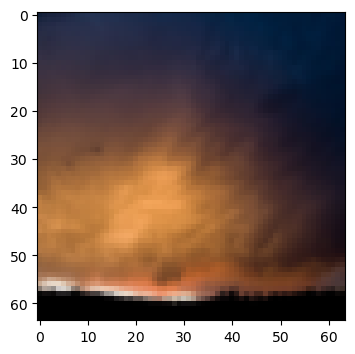

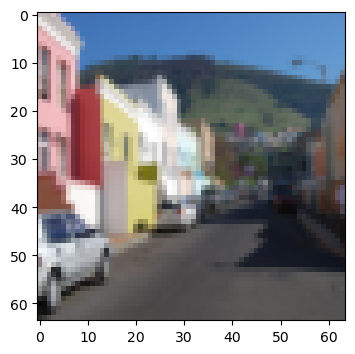

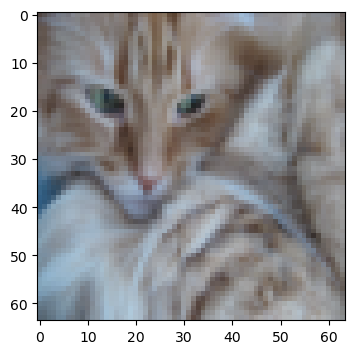

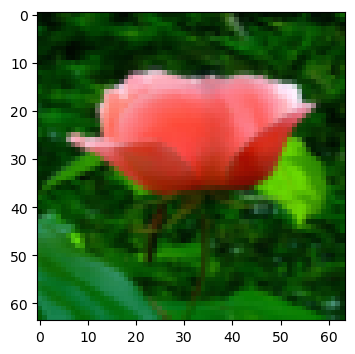

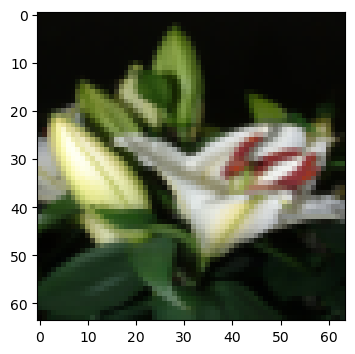

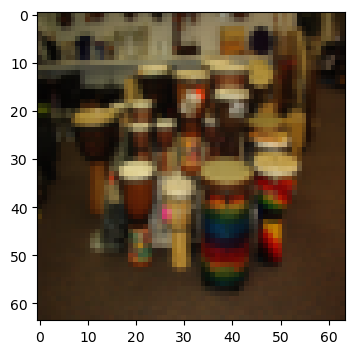

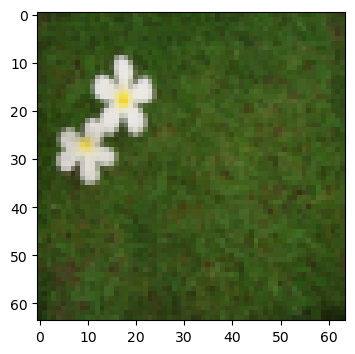

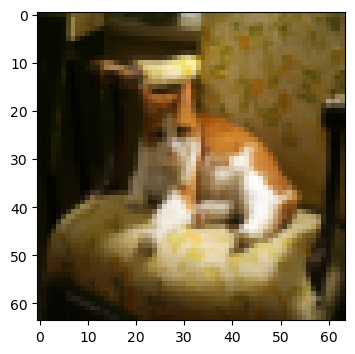

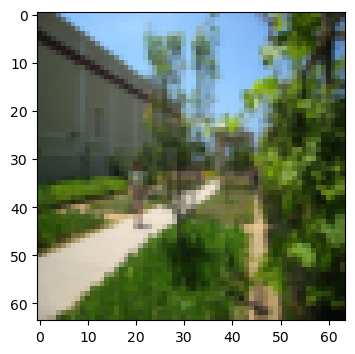

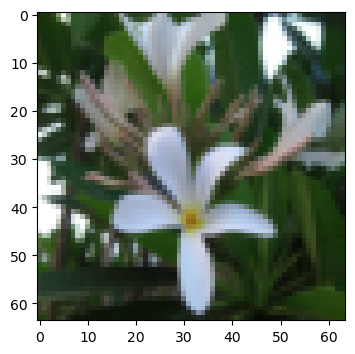

In [26]:
for i in range(0,10):
    plt.imshow(X_train[i])
    plt.show()

In [27]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(209, 64, 64, 3) (209,)
(50, 64, 64, 3) (50,)


In [28]:
X_train_flat = X_train.reshape(X_train.shape[0], -1) / 255.0
X_train_flat = X_train_flat.T
X_test_flat = X_test.reshape(X_test.shape[0], -1) / 255.0
X_test_flat = X_test_flat.T


y_train = y_train.reshape(-1, 1).T
y_test = y_test.reshape(-1, 1).T

print("X_train_flat:", X_train_flat.shape)   
print("y_train:", y_train.shape)             

print("X_test_flat:", X_test_flat.shape)     
print("y_test:", y_test.shape)               

X_train_flat: (12288, 209)
y_train: (1, 209)
X_test_flat: (12288, 50)
y_test: (1, 50)


In [29]:
layers_dims = [12288, 128, 64, 32, 1]

In [30]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.01, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    parameters = initialize_parameters_deep(layers_dims)
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        AL, caches = L_model_forward(X, parameters)
        
        # Compute cost.
        cost = compute_cost(AL, Y)
        
        # Backward propagation.
        grads = L_model_backward(AL, Y, caches)
  
        # Update parameters.
        parameters = update_parameters(parameters, grads, learning_rate)

        
        # Print the cost every 100 iterations and for the last iteration
        if print_cost and (i % 100 == 0 or i == num_iterations - 1):
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0:
            costs.append(cost)

    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (per 100)')
    plt.title(f"learning rate = {learning_rate}")
    plt.show()
        
    return parameters, costs

In [ ]:
parameters, costs = L_layer_model(X_train_flat, y_train, layers_dims, num_iterations = 2500, print_cost = True)

Cost after iteration 0: 0.990874169622029
Cost after iteration 100: 0.5003026334165596
Cost after iteration 200: 0.35941133410284926
Cost after iteration 300: 0.20592919886075703
Cost after iteration 400: 0.1127896698484176
Cost after iteration 500: 0.05836276544190532
Cost after iteration 600: 0.029963809422240903
Cost after iteration 700: 0.018509658818832538


In [ ]:
def predict(X, Y, parameters):
    AL, _ = L_model_forward(X, parameters)
    preds = (AL > 0.5)
    acc = np.mean(preds == Y)
    return preds, acc

In [ ]:
predict(X_train_flat, y_train, parameters)

In [ ]:
predict(X_test_flat, y_test, parameters)